In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from adjustText import adjust_text

from scipy.stats import ks_2samp, ttest_ind
from statsmodels.stats.multitest import multipletests

import scvi
from scvi.model import CondSCVI, DestVI

import umap
import torch
from torch.distributions import Gamma
import gseapy
import hotspot

from utils import *

%matplotlib inline

# import data and collide cell-types

In [3]:
sc_adata = sc.read_h5ad("scRNA-Tumor-compressed.h5ad")

In [4]:
sc_adata.obs["broad_labels"].value_counts()

Mon-Mac        4400
CD8            1021
CD4-Tregs       833
DCs             502
Neutrophils     186
NK              155
Tumor            88
Name: broad_labels, dtype: int64

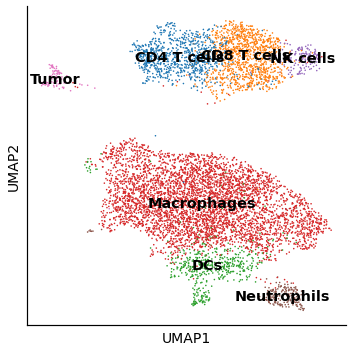

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(
    sc_adata, 
    color="broad_labels_",
    frameon=True,
    title="",
    legend_loc="on data",
    legend_fontsize="x-large",
    ax=ax, size=10, show=False,
)
plt.tight_layout()
plt.savefig("figures/UMAP_scRNA.pdf", dpi=DPI)

In [7]:
sc_adata.obs["broad_labels"].value_counts().sum()

7185

In [8]:
G = 4000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [9]:
sc_adata

AnnData object with n_obs × n_vars = 7185 × 4000
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'broad_labels', 'broad_labels_', 'ABfile', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden', 'leiden_2'
    var: 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi', 'broad_labels_colors', 'leiden', 'leiden_2_colors', 'neighbors', 'umap', 'broad_labels__colors', 'hvg', 'log1p'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## get intersection with spatial

In [10]:
st_adata = sc.read_h5ad("ST-Tumor-compressed.h5ad")

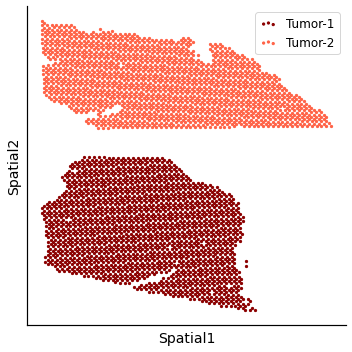

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
color_list = ["darkred", "tomato"]
name_list = ["Tumor-1", "Tumor-2"]
for i, value in enumerate(["A1", "B1"]):
    mask = st_adata.obs["tumor"] == value
    ax.scatter(st_adata.obsm["location"][mask, 0], st_adata.obsm["location"][mask, 1], 
               c=color_list[i], label=name_list[i], s=5)
ax.legend(frameon=True)
prettify_axis(ax, False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Spatial1")
ax.set_ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/spatial.pdf", dpi=DPI)

In [12]:
st_adata.obs["tumor"].value_counts(), st_adata.n_obs

(A1    2125
 B1    1902
 Name: tumor, dtype: int64,
 4027)

In [14]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

In [15]:
G = len(intersect)
print(G)

2886


In [16]:
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

## fit scRNA-seq model

In [17]:
scvi.data.setup_anndata(sc_adata, layer="counts", labels_key="broad_labels")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["broad_labels"]                                         
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 7185 cells, 2886 vars, 1 batches, 
         7 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 350/350: 100%|██████████| 350/350 [04:55<00:00,  1.18it/s, loss=585, v_num=1] 


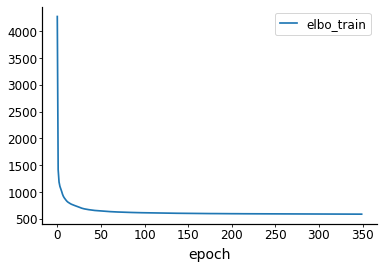

In [18]:
train = True
if train:
    # train the conditional VAE
    sc_model = CondSCVI(sc_adata)
    sc_model.train(max_epochs=350)
    sc_model.history["elbo_train"].plot()
    sc_model.save("sc_model", overwrite=True)
else:
    sc_model = CondSCVI.load("sc_model", sc_adata, use_gpu=True)

In [19]:
sc_adata.obsm["X_CondSCVI"] = sc_model.get_latent_representation()

## Deconvolution

In [20]:
# get dataset ready
scvi.data.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 4027 cells, 2886 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|██████████| 2500/2500 [26:20<00:00,  1.58it/s, loss=1.21e+07, v_num=1]


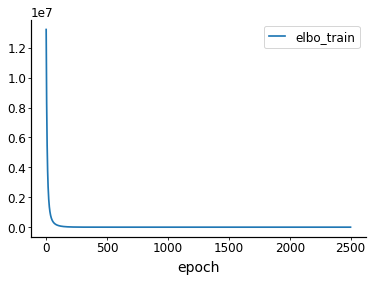

In [22]:
# add here number of cell type
train_st = True
if train_st:
    st_model = DestVI.from_rna_model(st_adata, sc_model)
    st_model.train(max_epochs=2500)
    st_model.history["elbo_train"].plot()
    st_model.save("st_model", overwrite=True)
else:
    st_model = DestVI.load("st_model", st_adata)

In [23]:
st_adata.obsm["proportions"] = st_model.get_proportions()
gamma = st_model.get_gamma(return_numpy=True)

## Statistics on proportions

In [24]:
loc = pd.DataFrame(data=st_adata.obsm["location"], index=st_adata.obs.index)
hs = hotspot.Hotspot(st_adata.obsm["proportions"].T, model='none', latent=loc,)

hs.create_knn_graph(
    weighted_graph=True, n_neighbors=50,
)

hs_results = hs.compute_autocorrelations(jobs=1)

hs_results

100%|██████████| 7/7 [00:00<00:00, 12.92it/s]


C          Z           Pval            FDR
Gene                                                          
Neutrophils  0.968458  31.730973  2.905940e-221  2.034158e-220
CD8          0.919550  20.907319   2.296645e-97   8.038256e-97
Mon-Mac      0.909687   7.850526   2.071483e-15   4.833460e-15
DCs          0.810263   1.170375   1.209250e-01   2.116187e-01
Tumor        0.946102   0.640195   2.610228e-01   3.298170e-01
NK           0.571879   0.574838   2.827003e-01   3.298170e-01
CD4-Tregs    0.413867   0.279327   3.899970e-01   3.899970e-01

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel/__main__.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


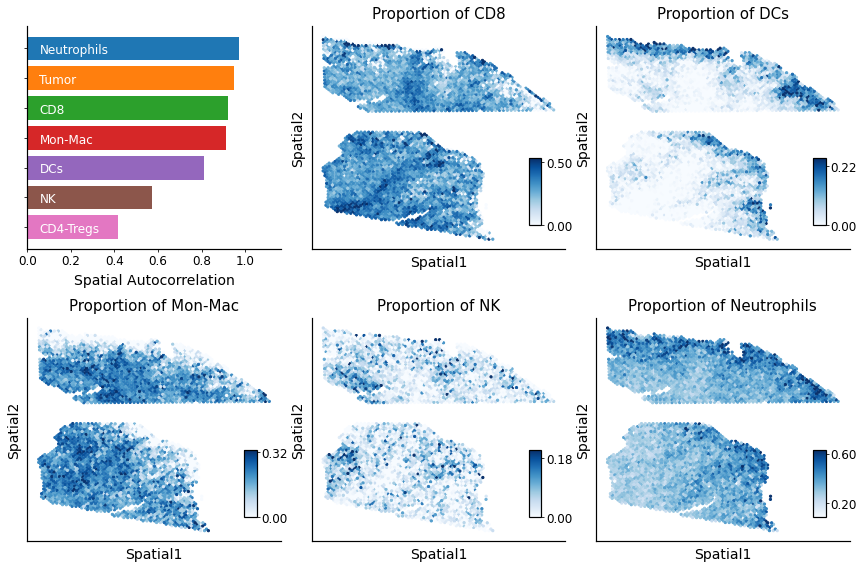

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
ct_list = st_adata.obsm["proportions"].columns
for i in range(2):
    for j in range(3):
        if i + j == 0:
            prettify_axis(axes[0, 0])
            axes[0, 0].margins(x=0.2)
            bar_data = hs_results.sort_values("C", ascending=True)
            axes[i, j].barh(np.arange(bar_data.shape[0]), bar_data["C"].values, 
                            color=sns.color_palette()[0:bar_data.shape[0]][::-1])
            axes[i, j].set_yticks(np.arange(bar_data.shape[0]))
            axes[i, j].set_yticklabels( bar_data.index.values, horizontalalignment = "left", color="white")
            axes[i, j].set_xlabel("Spatial Autocorrelation")
            axes[i, j].tick_params(axis='y', pad=-15)
        else:         
            
            prettify_axis(axes[i, j], False)
            data = st_adata.obsm["proportions"][ct_list[i*3 + j]]
            vmax = np.quantile(data, 0.99)
            scplot = axes[i, j].scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                    c=data, s=5, cmap="Blues", vmax=vmax)
            a, b = np.quantile(data, 0.01),np.quantile(data, 0.98)
            ta, tb = ["{:0.2f}".format(x) for x in (a, b)]
            cax = inset_axes(axes[i, j], width="5%", height="30%", loc=4, borderpad=2) 
            cbar = plt.colorbar(scplot, cax=cax, orientation="vertical")
            cbar.set_ticks([a, b])
            cbar.set_ticklabels([ta, tb])
            axes[i, j].set_title(F"Proportion of {ct_list[i*3+j]}")
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].set_xlabel("Spatial1")
            axes[i, j].set_ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/proportions.pdf", dpi=DPI)

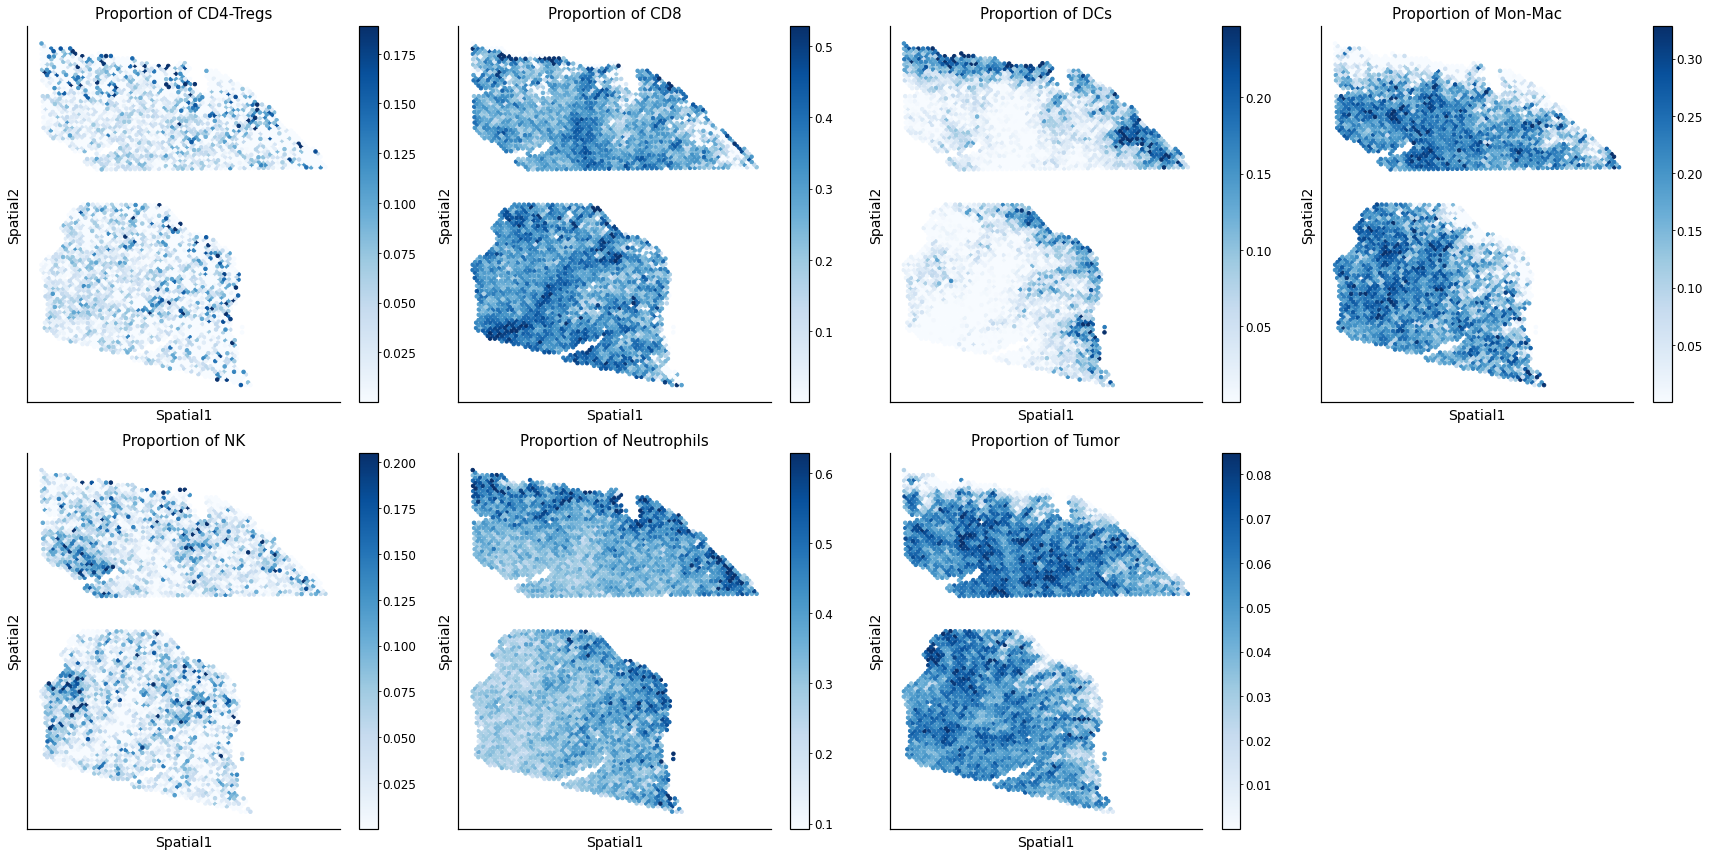

In [30]:
# all cell types for supplements
# selected cell type for paper
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
for i in range(2):
    for j in range(4):
        if i*4 + j < 7:
            prettify_axis(axes[i, j], False)
            data = st_adata.obsm["proportions"][ct_list[i*4 + j]]
            vmax = np.quantile(data, 0.99)
            scplot = axes[i, j].scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                c=data, s=12, cmap="Blues", vmax=vmax)
            plt.colorbar(scplot, ax=axes[i, j])
            axes[i, j].set_title(F"Proportion of {ct_list[i*4+j]}")
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].set_xlabel("Spatial1")
            axes[i, j].set_ylabel("Spatial2")
        else:
            prettify_axis(axes[i, j], True)

plt.tight_layout()
plt.savefig("figures/proportions_supp.pdf", dpi=DPI)

##  Show proportion for every cell type spatially and find characteristic proportions

100%|██████████| 100/100 [00:00<00:00, 7504.84it/s]

CD4-Tregs ANALYSIS:


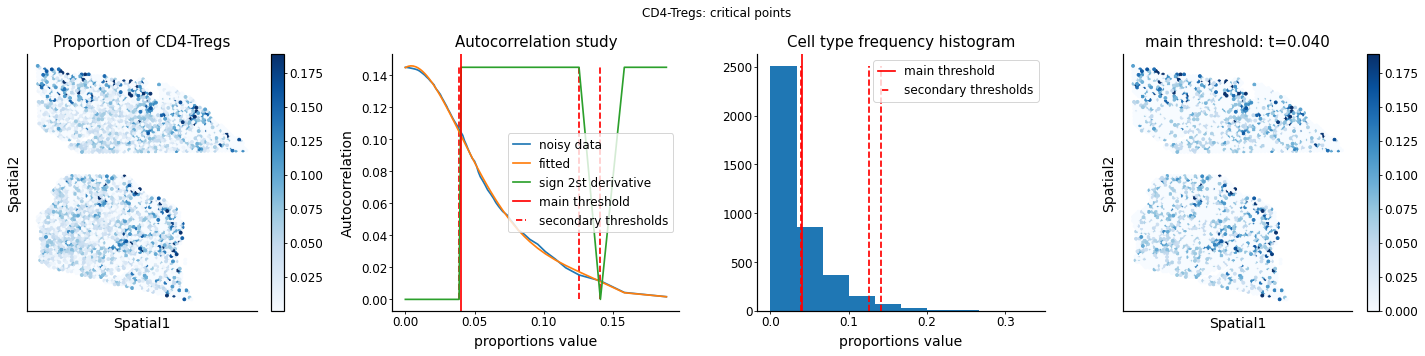

100%|██████████| 100/100 [00:00<00:00, 7762.77it/s]

CD8 ANALYSIS:


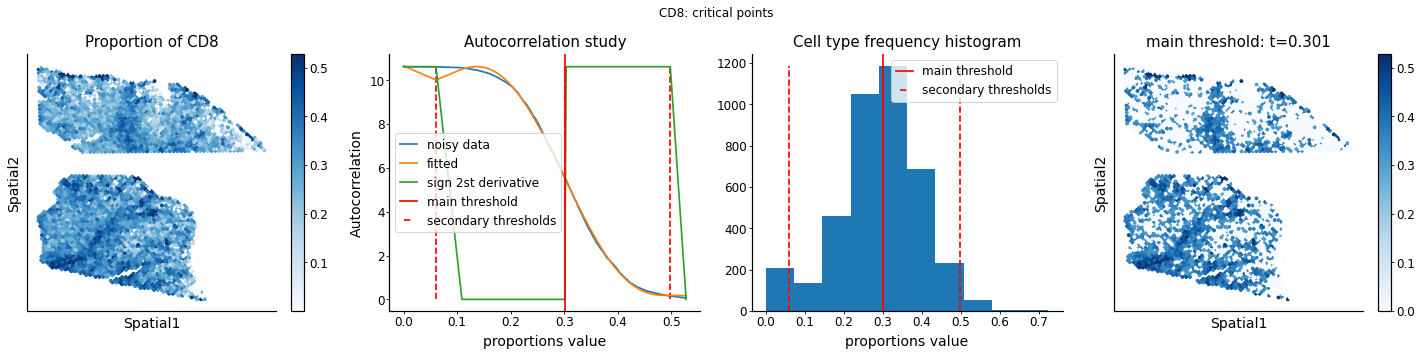

100%|██████████| 100/100 [00:00<00:00, 8231.71it/s]

DCs ANALYSIS:


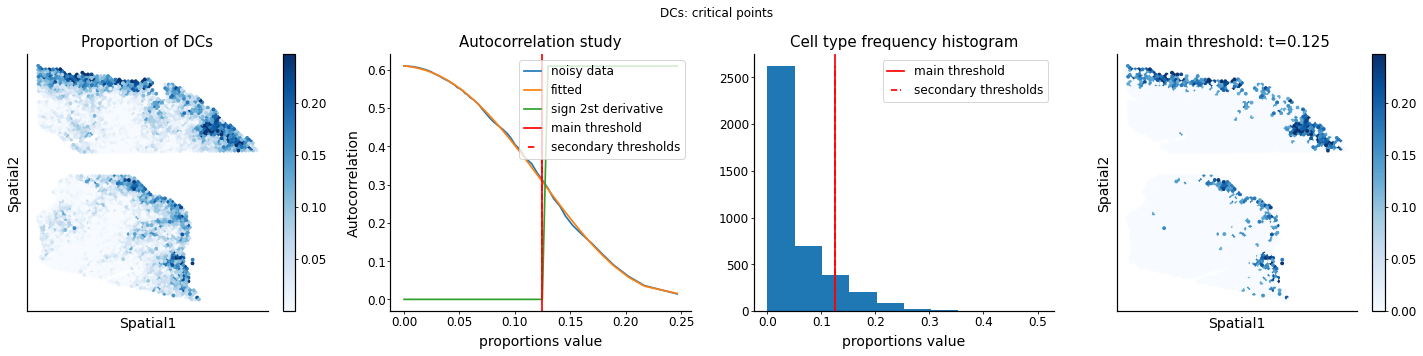

100%|██████████| 100/100 [00:00<00:00, 7099.84it/s]

Mon-Mac ANALYSIS:


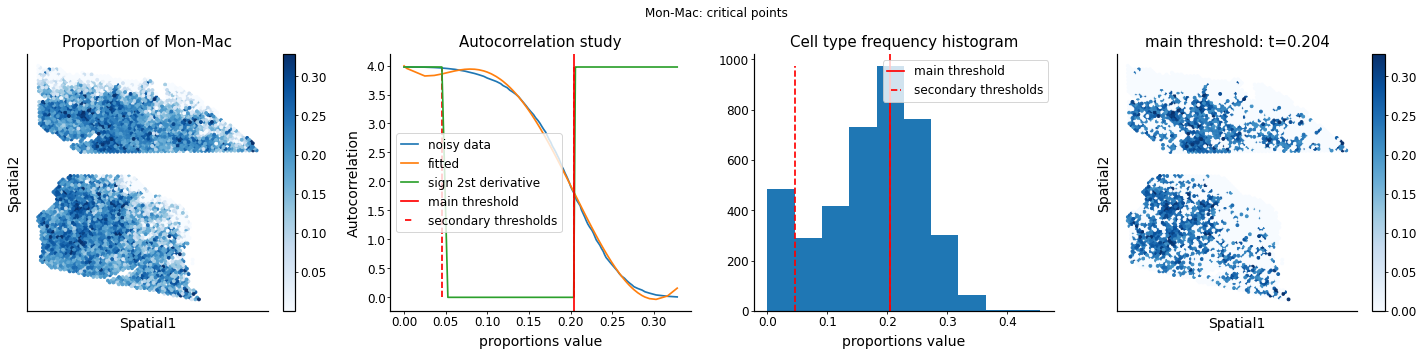

100%|██████████| 100/100 [00:00<00:00, 7705.02it/s]

NK ANALYSIS:


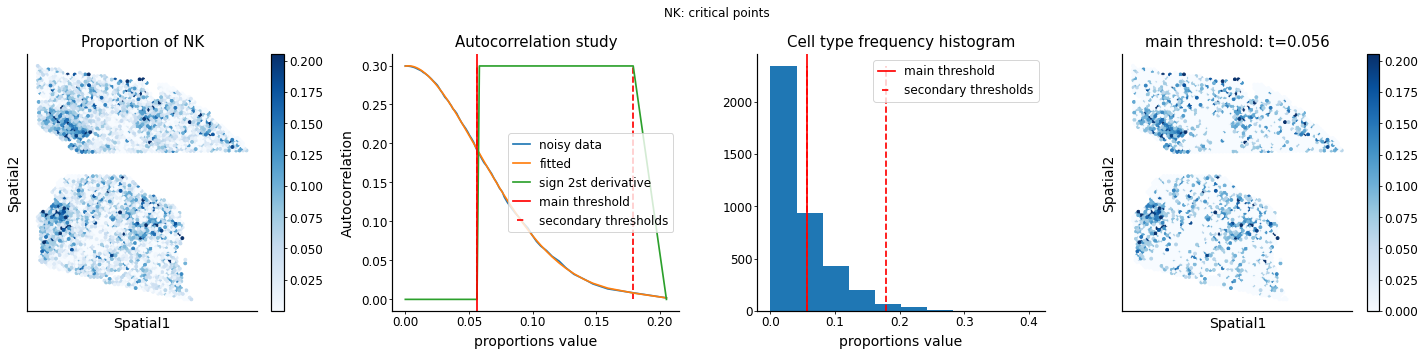

100%|██████████| 100/100 [00:00<00:00, 7827.24it/s]

Neutrophils ANALYSIS:


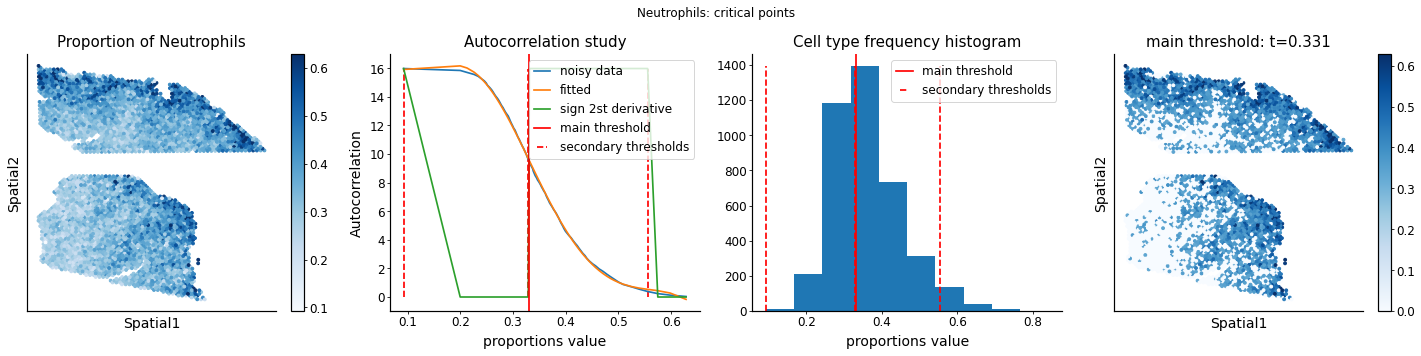

100%|██████████| 100/100 [00:00<00:00, 7402.98it/s]

Tumor ANALYSIS:


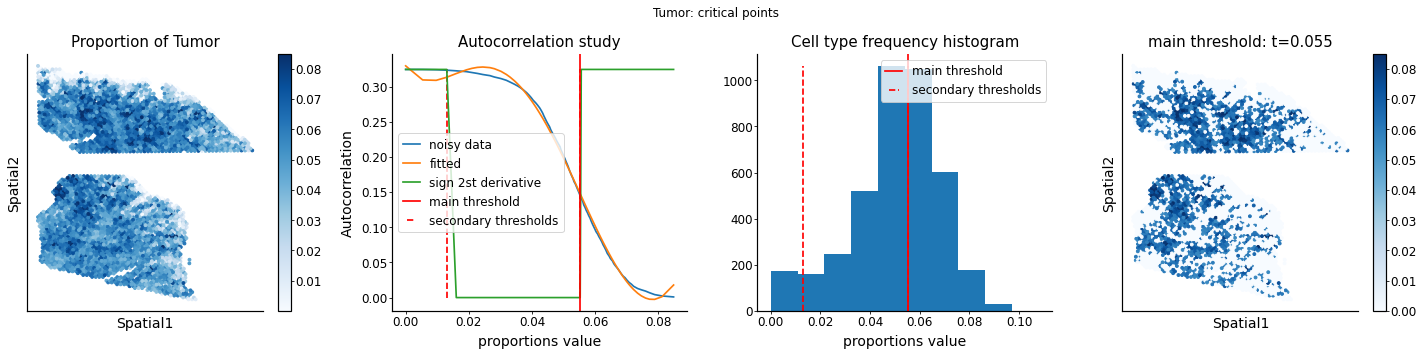

In [31]:
ct_thresholds = {}
nominal_threshold = {}
for name_ct in ct_list:
    # show proportions
    print(name_ct + " ANALYSIS:")
    array = st_adata.obsm["proportions"][name_ct]
    
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(name_ct+": critical points")
    ax1 = plt.subplot(141)
    prettify_axis(ax1, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    vmax = np.quantile(array.values, 0.99)
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
            c=array, s=8, cmap="Blues", vmax=vmax)
    plt.colorbar()
    plt.title("Proportion of "+name_ct)

    # get characteristic values
    quantiles, stack = form_stacked_quantiles(array.values)
    index, z_values = get_autocorrelations(st_adata, stack, quantiles)
    z_values, smoothed, derivative, sign_2nd, _ = smooth_get_critical_points(index, z_values, s=0.1)

    #plot characteristic plots
    ymax = np.max(z_values)
    ax2 = plt.subplot(142)
    prettify_axis(ax2)
    plt.plot(index, z_values, label="noisy data")
    plt.plot(index, smoothed, label="fitted")
    plt.plot(index, ymax * sign_2nd, label="sign 2st derivative")
    # identify points
    ipoints = index[np.where(sign_2nd[:-1] != sign_2nd[1:])[0]]
    plt.vlines(ipoints, ymin=0, ymax=np.max(z_values), color="red", linestyle="--", label="secondary thresholds")
    # nominal mapping
    nom_map = index[np.argmin(derivative)]
    plt.axvline(nom_map, c="red", label="main threshold")
    plt.ylabel("Autocorrelation")
    plt.xlabel("proportions value")
    plt.title("Autocorrelation study")
    plt.legend()
    
    # plot on top of histogram
    ax3 = plt.subplot(143)
    prettify_axis(ax3)
    n, bins, patches = plt.hist(array.values)
    plt.vlines(ipoints, ymin=0, ymax=np.max(n), color="red", linestyle="--", label="secondary thresholds")
    # nominal mapping
    plt.axvline(nom_map, c="red", label="main threshold")
    plt.xlabel("proportions value")
    plt.title("Cell type frequency histogram")
    plt.legend()
    
    # add thresholds to dict
    nominal_threshold[name_ct] = nom_map
    ct_thresholds[name_ct] = ipoints
    
    ax4 = plt.subplot(144)
    prettify_axis(ax4, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")    # show binarization for every ipoint
    p = nom_map
    vmax = np.quantile(array.values, 0.99)
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                c=array.values * (array.values > p), s=8, cmap="Blues", vmax=vmax)
    plt.title("main threshold: t={:0.3f}".format(p))
    plt.colorbar()
    plt.tight_layout()
    plt.show()

### Now, for every cell type, we wish to explore the gamma space



CD4-Tregs ANALYSIS:


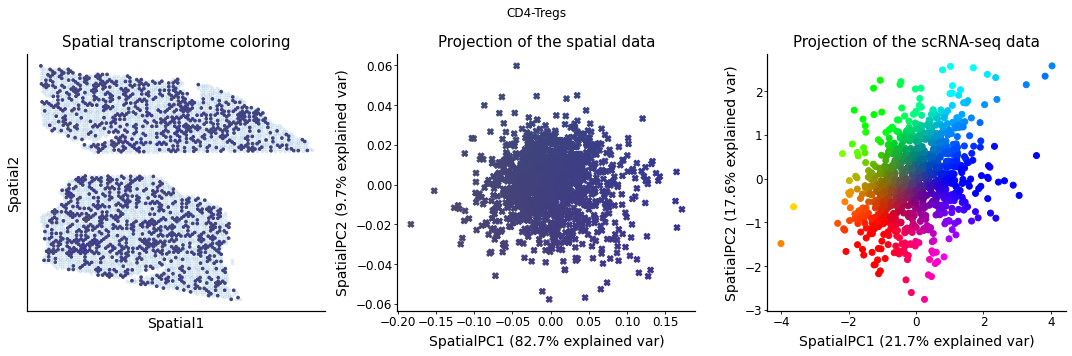



Component:0

top
Gm15956, Jph1, Rslcan18, C030010L15Rik, Islr, Itga8, Ephx3, C130050O18Rik, Itgb5, Epb41l3, Rps13, Itpka, C1qtnf3, C1s1, Rnft2, Rnf183, Jag2, Jam2, C630043F03Rik, Cachd1, Eng, Cacna1c, Rin1, Bvht, Ereg, Irx5, Samd4, Scx, Sctr, Scrn1, Bok, Schip1, Scd1, Scamp5, Sbsn, Saxo2, Samd14, Runx2os2, Evc2, Saa3, Evc, S100g, S100a9, Iqcd, Iqck, Btnl2, Etv1, Cacna2d1, Rhpn1, Hoxc10



/home/ubuntu/destVI-paper-code/tumor/deconvolution/utils.py:135: RuntimeWarning: invalid value encountered in true_divide
  r = r_num/r_den


Arrhythmogenic right ventricular cardiomyopathy (ARVC), Dilated cardiomyopathy, Integrin cell surface interactions, Integrin family cell surface interactions, Beta-1 integrin cell surface interactions, Cardiac muscle contraction, ECM-receptor interaction, Cross-presentation of particulate exogenous antigens (phagosomes), Integrin-mediated cell adhesion, Opening of calcium channels triggered by depolarization of the presynaptic terminal

bottom
Tnfrsf9, Il2ra, Tnfrsf4, Gzmb, Foxp3, Tnfrsf18, Ikzf2, Isg20, Sdf4, Socs1, Cd74, Cxcl10, Igtp, Izumo1r, Ctla2a, Cish, Ctla4, Bnip3, Ecm1, Ifit1, Cd2, Itgae, Odc1, Ccnd2, Mxd1, Klrg1, Usp18, Socs2, Bst2, Rsad2, Iigp1, C1qtnf12, Icos, Gimap7, Ccrl2, Tnfrsf8, H2-Ab1, Ikzf4, Ifit3, Pmepa1, Hp, Chil3, Cd14, Hilpda, Adgre1, Il2rb, Igkc, Ly6c1, Mafb, Src

Immune system, CD8/T cell receptor downstream pathway, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Interferon alpha/beta signaling, Interleukin-2 signaling pat

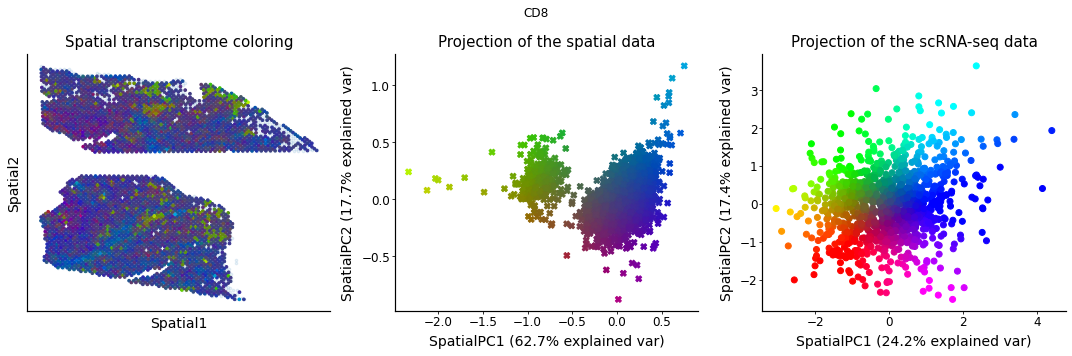



Component:0

top
Plpp7, Shroom4, Foxg1, C130050O18Rik, Foxc1, C1qtnf3, Itpka, C1s1, Ddr2, C4b, C630043F03Rik, Cabp4, Mgll, Cachd1, Serpine1, Serpind1, Cacna1c, Cacna1s, Cacna2d1, Shroom3, Siglecg, S1pr3, Siglech, Slc27a3, Fxyd2, Npl, Btnl2, Irx5, Slc22a23, Slc22a18, Btnl9, Islr, Fpr1, Slc13a3, Npy, Bvht, Itga8, C030010L15Rik, C030037D09Rik, C130013H08Rik, Serpinb2, Cadm1, Eepd1, Jag2, D330050G23Rik, Scin, Nuak1, K230015D01Rik, Kazald1, Flt4

Fibroblast growth factor 1, Arrhythmogenic right ventricular cardiomyopathy (ARVC), Cardiac muscle contraction, Dilated cardiomyopathy, Dissolution of fibrin clot, Fibrinolysis pathway, Complement and coagulation cascades, Blood clotting cascade, BDNF signaling pathway, Urokinase-type plasminogen activator (uPA) and uPAR-mediated signaling

bottom
Ifit3, Ifit1, Ifit1bl1, Isg20, Rsad2, Usp18, Ifit3b, Igtp, Slfn5, Gbp2, Bst2, Gzmb, Ly6a, Ifih1, Ifi208, Ifit2, Irgm1, Ifi214, Cmpk2, Phf11c, Cd8a, Cxcl10, Ccrl2, Iigp1, AW112010, Jaml, Mxd1, Pdcd1, Gzm

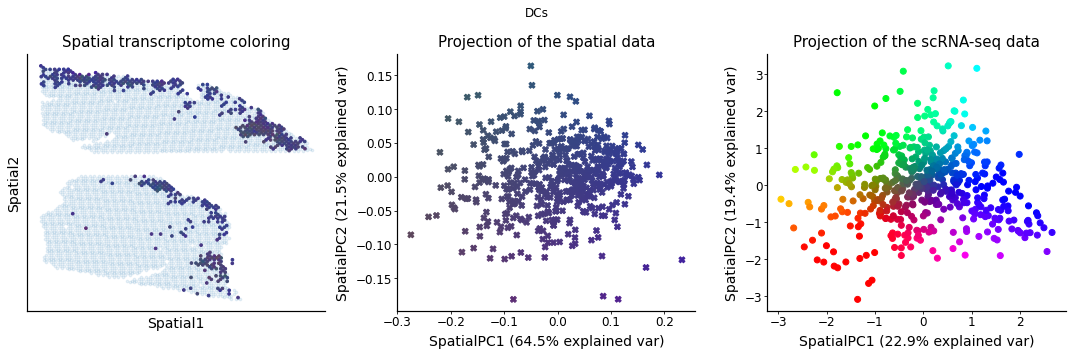



Component:0

top
Spats2l, Sgcd, Pcdhb7, Shisa4, Shf, Bcl11b, Mtfp1, Bcl2l15, Bcl6b, Sgip1, Bdkrb2, Gm13199, Col8a1, Bhlhe22, Col9a3, Epb41l5, Serping1, Gm12992, Serpine2, Bicdl1, Gm12932, Echdc2, Pcdh7, Shox2, Shroom3, Shroom4, Creb3l3, Cpxm1, Ephb3, BC049352, Slc22a18, BC049715, BC051142, Bace2, Cpm, Gm14010, Gm13470, Skap1, Pbp2, Bcat1, Six2, Pbx4, Sit1, Ebf3, Pcdh19, Myo3b, Serpinb2, Samd14, Penk, Epb41l4a

Syndecan 1 pathway, Collagen biosynthesis and modifying enzymes, Complement and coagulation cascades, Integrins in angiogenesis, Organic cation transport, Dissolution of fibrin clot, Extracellular matrix organization, Valine, leucine and isoleucine biosynthesis, Organic cation/anion/zwitterion transport, Coagulation intrinsic pathway

bottom
H2-Ab1, H2-Eb1, Cd72, H2-Aa, Il1r2, Cd74, Slamf9, H2-DMb1, Cdca3, Top2a, Hexb, Ly6a, Ifitm1, H2-DMb2, Spint1, Stmn1, Nusap1, Ccnb2, Cdk1, Selenoh, Dctpp1, Mcm5, Spc24, Parvg, H2-Oa, Hist1h2ao, Pltp, Cdca8, Birc5, Axl, Cenpa, Mki67, Sh2d1b1,

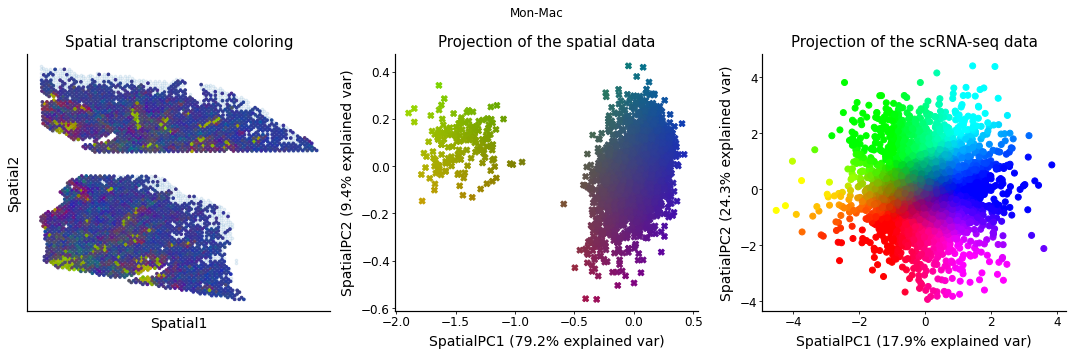



Component:0

top
2700069I18Rik, Rem2, Efna2, Klra5, Gm11714, Aknad1, Ptprg, Dzip1, Gzmf, Kcnj8, Muc20, Ppp1r14c, Akr1c14, Fam71b, Naalad2, 1700001O22Rik, Nbl1, Ncald, Upk1a, Nckap5, Utf1, Arnt2, Nefh, Platr22, Gm15634, Gm15473, Il5, Ninj2, Ypel4, Tmem150c, Gjb4, Perp, Mid2, Slc35f2, Slc6a17, Lurap1, Shroom3, Gng3, Ephb3, Hemgn, Serp2, Apol10b, Cd79a, Sema6d, Endou, Scin, Gpha2, A630023P12Rik, Cfap69, Ankrd6

Activation of kainate receptors upon glutamate binding, Inwardly rectifying potassium channels, Eosinophils in the chemokine network of allergy, Activation of calcium-permeable kainate receptor, Potassium channels, Neuronal system, Hematopoiesis regulation by cytokines, Other semaphorin interactions, Glycosylphosphatidylinositol (GPI) biosynthesis, Dendritic cells in regulating TH1 and TH2 development

bottom
F13a1, Thbs1, Pf4, Ccl9, Lyz2, Ccl2, Adam8, Emp1, Ccl6, Lyz1, Ctsl, Ccl7, Ier3, Cd14, Cmpk2, Rsad2, Fn1, Osm, Ctsd, Cxcl2, Mxd1, Cd93, Spp1, Abca1, Ccl4, Slfn5, Hp, Ninj1, F

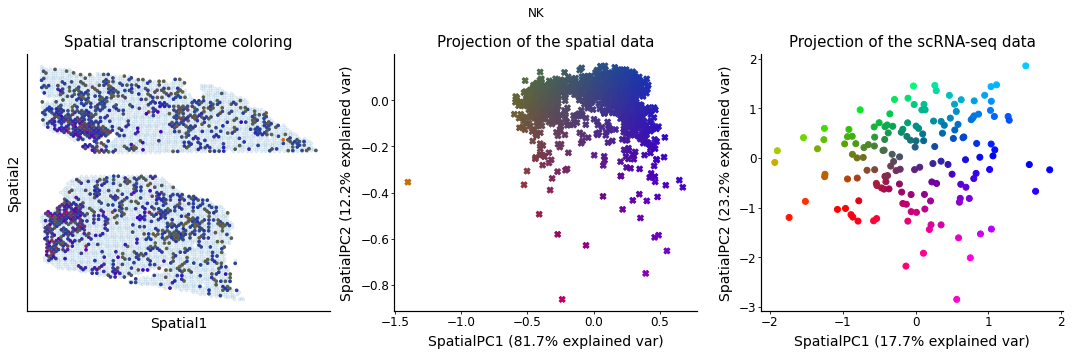



Component:0

top
Zscan20, Fabp4, Fads6, Fads3, Fads2, Nos2, Nos3, Noxo1, Fabp5, Npdc1, Npl, Npy, Cxcl12, Nr2c1, Nr2f1, Nr2f2, Faah, F7, F630040K05Rik, Nrbp2, Nrep, Nrg1, Fah, Fahd1, Fam129c, Fam160a1, Fam83d, Fam83a, Ngf, Fam71e1, Nhs, Nhsl1, Nid1, Nid2, Fam71b, Fam3b, Fam229b, Fam20c, Nlgn2, Fam187b, Fam178b, Fam174b, Nnmt, Nnt, Fam161a, Nrn1, F3, F2rl3, Epb41l4a, Epas1

Extrinsic pathway, Nitric oxide effects, Extrinsic prothrombin activation pathway, PPAR signaling pathway, Nicotinate and nicotinamide metabolism, Ghrelin pathway, TWEAK regulation of gene expression, Nitric oxide stimulation of guanylate cyclase, Fibrin clot formation (clotting cascade), Interleukin-1 regulation of extracellular matrix

bottom
Gzma, Ccl4, Cdkn2d, Gzmb, Cct8, Nkg7, Klri2, Cst7, Ccl3, Tbx21, Serbp1, Ccnd2, Sept1, Ccl5, Tspan13, Slc41a1, Hcst, Impa2, Orc6, Abcb1a, Ak2, Eomes, Gale, Klrg1, E130308A19Rik, Lockd, Hmgcs1, Ikzf3, Wdr95, B930036N10Rik, Zcchc24, Zbtb32, Klre1, Enpp4, Klrb1c, Pim2, Serpinb9, 

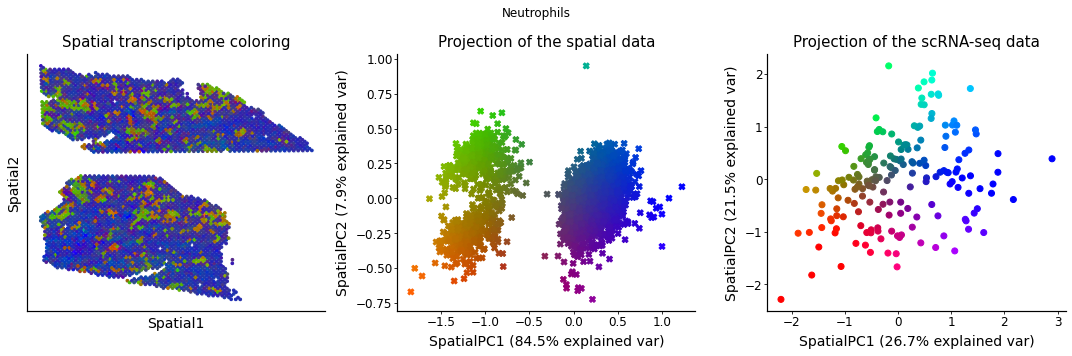



Component:0

top
Zscan20, Ccr9, Ccr7, Ccr10, Ccno, Ccnf, Ccne2, Ccne1, Itm2a, Itpka, Izumo1r, Izumo4, Jag2, Jam2, Ccnb1, Jazf1, Jcad, Jph1, Jrk, Ccl22, K230015D01Rik, Kazald1, Ccl11, Kbtbd6, Kcnd1, Kcne3, Kcng2, Kcnh2, Kcnip2, Itga8, Islr, Cfh, Cd160, Cd3g, Cd3d, Cd320, Cd300e, Il2, Cd28, Cd27, Il2ra, Il2rb, Il33, Cd247, Il5, Cd22, Cd209f, Cd209d, Inca1, Inpp4b

Tob role in T-cell activation, Cytokine-cytokine receptor interaction, Interleukin-12/STAT4 pathway, T cell activation co-stimulatory signal, HIV-induced T cell apoptosis, Inflammatory response pathway, Interleukin-12-mediated signaling events, CD8/T cell receptor downstream pathway, T helper cell surface molecules, Intestinal immune network for IgA production

bottom
Ifit3b, Gbp2, Rsad2, Ifit1, Ifit3, Ifit2, Slfn4, Cxcl10, Irgm1, Slfn5, Acod1, Isg20, Il1rn, Gbp5, Cmpk2, Socs1, Ifih1, Ccrl2, Plac8, Oasl1, Pnp, Ly6a, Ccl4, Il1a, Usp18, Igtp, Ifi208, Nfkbia, Cxcl2, Il1r2, Samd9l, Ifi205, Ier3, Ndc80, Ffar2, Ddx27, Mefv, Cdkn1a,

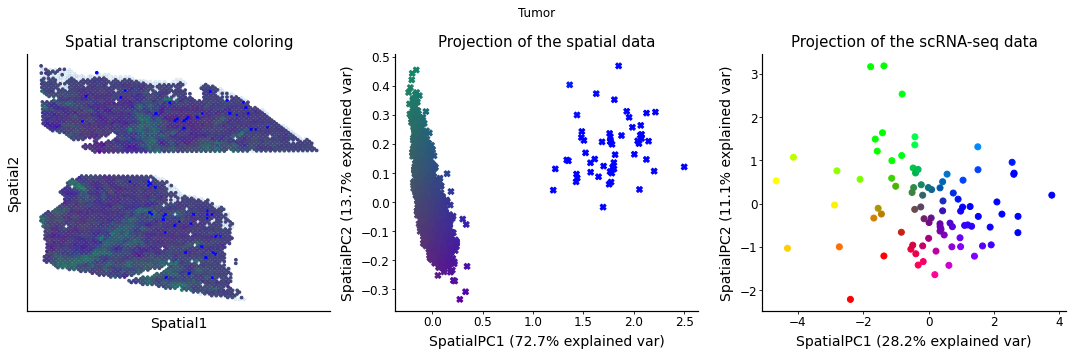



Component:0

top
Zscan20, Sgip1, Gm17745, Gm17767, Gm19585, Gm20069, Gm20627, Gm20632, Serpine2, Gm26542, Gm26571, Serpinb9b, Gm26902, Gm26935, Serpinb2, Gm27042, Gm28347, Gm28935, Gm29156, Gm29243, Gm29361, Gm17455, Sh2d1a, Gm3716, Sh2d1b1, Gm15473, Gm15518, Gm15634, Gm15708, Gm15747, Gm15787, Gm16008, Sit1, Siglech, Siglecg, Gm16096, Gm16253, Gm16283, Gm16287, Gm16315, Gm16556, Gm1673, Gm16845, Sh2d2a, Sema6d, Gm37170, H2-Oa, Gpm6b, Gpr174, S1pr5

Lysosphingolipid and lysophosphatidic acid (LPA) G-protein coupled receptors, Dissolution of fibrin clot, S1P/S1P4 pathway, Fibrinolysis pathway, Other semaphorin interactions, Glycosylphosphatidylinositol (GPI) biosynthesis, Blood clotting cascade, Signal transduction of S1P receptor, Fibroblast growth factor 1, Post-translational modification: biosynthesis of GPI-anchored proteins

bottom
Dkc1, Anp32b, Ncl, Nop58, Set, Smc1a, Cct8, Mcm2, Cdca5, Snrpd1, Nhp2, Smc4, Mki67, Asf1b, Kif20b, Map1b, Nip7, Cenpe, Serbp1, Psph, Smc2, Fkbp4, Mcm3

In [34]:
for name_ct in ct_list:
    # show proportions
    print("\n" + name_ct + " ANALYSIS:")
    # find the components
    filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
    locations = st_adata.obsm["location"][filter_]
    proportions = st_adata.obsm["proportions"][name_ct].values[filter_]
    ct_index = np.where(name_ct == st_model.cell_type_mapping)[0][0]
    data = gamma[:, :, ct_index][filter_]
    vec = get_spatial_components(locations, proportions, data)
    # project data onto them
    projection = np.dot(data - np.mean(data, 0), vec)

    # create the colormap
    cmap = cmap2d.TernaryColorMap(tri_coords, tri_colors)

    # apply colormap to spatial data
    color = np.vstack([cmap(projection[i]) for i in range(projection.shape[0])])
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(name_ct)
    ax1 = plt.subplot(132)
    prettify_axis(ax1)
    plt.scatter(projection[:, 0], projection[:, 1],c=color, marker="X")
    # variance and explained variance
    total_var = np.sum(np.diag(np.cov(data.T)))
    explained_var = 100 * np.diag(np.cov(projection.T)) / total_var 
    plt.xlabel("SpatialPC1 ({:.1f}% explained var)".format(explained_var[0]))
    plt.ylabel("SpatialPC2 ({:.1f}% explained var)".format(explained_var[1]))
    plt.title("Projection of the spatial data")

    ax3 = plt.subplot(131)
    prettify_axis(ax3, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.1, s=7)
    plt.scatter(st_adata.obsm["location"][filter_, 0], st_adata.obsm["location"][filter_, 1], 
                c=color, s=7)
    plt.title("Spatial transcriptome coloring")

    # go back to the single-cell data and find gene correlated with the axis
    sc_adata_slice = sc_adata[sc_adata.obs["broad_labels"] == name_ct]
    normalized_counts = sc_adata_slice.X.A
    sc_latent = sc_adata_slice.obsm["X_CondSCVI"]
    sc_projection = np.dot(sc_latent - np.mean(sc_latent,0), vec)

    # show the colormap for single-cell data
    color = np.vstack([cmap(sc_projection[i]) for i in range(sc_projection.shape[0])])
    ax2 = plt.subplot(133)
    prettify_axis(ax2)
    plt.scatter(sc_projection[:, 0], sc_projection[:, 1],c=color)
    # variance and explained variance
    total_var = np.sum(np.diag(np.cov(sc_latent.T)))
    explained_var = 100 * np.diag(np.cov(sc_projection.T)) / total_var 
    plt.xlabel("SpatialPC1 ({:.1f}% explained var)".format(explained_var[0]))
    plt.ylabel("SpatialPC2 ({:.1f}% explained var)".format(explained_var[1]))
    plt.title("Projection of the scRNA-seq data")
    plt.tight_layout()
    plt.show()

    # calculate correlations, and for each axis:
    # (A) display top 50 genes + AND - (B) for each gene set, get GSEA 
    for d in [0, 1]:
        print("\n")
        print("Component:" + str(d))
        r = vcorrcoef(normalized_counts.T, sc_projection[:, d])
        for mode in ["top", "bottom"]:
            print("\n" + mode)
            ranking = np.argsort(r)
            if mode == "top":
                ranking = ranking[::-1]
            gl = list(st_adata.var.index[ranking[:50]])
            print(", ".join(gl) + "\n")
            enr = gseapy.enrichr(gene_list=gl, description='pathway', 
                                 gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
            print(", ".join(enr.results.head(10)["Term"].values))


### Last piece of automated analysis, look for Hotspot modules in the imputed values

In [37]:
#fix a cell type
for name_ct in ct_list:
    # show proportions
    print("\n" + name_ct + " ANALYSIS:")

    # get data
    filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
    locations = st_adata.obsm["location"][filter_]
    proportions = st_adata.obsm["proportions"][name_ct].values[filter_]

    # impute
    imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

    # run hotspot
    loc = pd.DataFrame(data=locations, index=st_adata.obs.index[filter_])
    df = pd.DataFrame(data=imp_ge.T, 
                      columns=st_adata.obs.index[filter_], index=st_adata.var.index)
    # run hotspot
    hs = hotspot.Hotspot(df, model='none', latent=loc,)
    hs.create_knn_graph(
            weighted_graph=True, n_neighbors=5,
        )
    hs_results = hs.compute_autocorrelations(jobs=1)

    gl = list(hs_results.index[:50])
    print(", ".join(gl) + "\n")
    enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
    print(", ".join(enr.results.head(10)["Term"].values))

 64%|██████▍   | 1855/2886 [00:00<00:00, 18540.65it/s]


CD4-Tregs ANALYSIS:


100%|██████████| 2886/2886 [00:00<00:00, 18162.64it/s]


Rpl8, Ly6a, Rpl4, Col3a1, Rps13, Gas5, Lgals1, Bst2, Gzmf, Gzmc, Dcn, Mt1, Tmem176b, Cst3, Spp1, Hsp90ab1, Npm1, Calr, Zfas1, Ly6c1, Ndrg1, Lrig1, Hint1, Iigp1, Cd9, Hspa5, Mgp, Tubb5, Gabarapl1, Eif5a, Gnas, Igfbp6, Bgn, Hspe1, Sdf4, Cct5, Igtp, Trib2, Tmem176a, Nrn1, Cd63, Mt2, H1f0, Rpn2, Sqstm1, Uqcc2, AW112010, Hsp90b1, Tuba1b, Atp5a1

Protein metabolism, Activation of chaperones by ATF6 alpha, Disease, Protein processing in the endoplasmic reticulum, Small leucine-rich proteoglycan (SLRP) molecules, T cell receptor regulation of apoptosis, Dermatan sulfate biosynthesis, Diabetes pathways, Influenza infection, Chondroitin sulfate/dermatan sulfate degradation

CD8 ANALYSIS:


100%|██████████| 2886/2886 [00:00<00:00, 6781.79it/s]


Rps13, Rpl8, Ly6a, Rpl4, Lgals1, Bst2, Gas5, Ly6c1, Gzmf, Cst3, Mt1, Hsp90ab1, Gnas, Ccl5, Calr, Npm1, AW112010, Hint1, Tnfrsf9, Gzmb, Spp1, Eef1d, Zfas1, Tubb5, Hspa5, Ctsd, Atp5a1, Hspe1, Eif5a, Snhg12, Hsp90b1, Serbp1, Cct5, Sqstm1, Sdf4, Slc25a4, Igtp, Snhg6, Gzmc, Dcn, Gm42418, Mt2, Ifit3, Rpn2, Uqcc2, Ctla2a, Ran, Iigp1, Tuba1b, Anxa1



100%|██████████| 2886/2886 [00:00<00:00, 27130.74it/s]

Protein metabolism, T cell receptor regulation of apoptosis, Activation of chaperones by ATF6 alpha, Disease, Influenza infection, Translation, Protein processing in the endoplasmic reticulum, Interactions of HIV Vpr protein with host cellular proteins, Electron transport reaction in mitochondria, Corticosteroids and cardioprotection

DCs ANALYSIS:
Ly6a, Cst3, Cd74, Mt1, Bst2, H2-Aa, Rpl8, H2-Ab1, Apod, H2-Eb1, Lgals1, Spp1, Rpl4, AA467197, Fn1, Gas5, Cxcl10, Calr, Iigp1, Syngr2, Sdc4, H2-DMb1, Anxa1, Phf11d, H1f0, Hsp90ab1, Tuba1b, Plac8, Ndrg1, Eif5a, Nupr1, Rps13, Ifi205, Ccl17, Cd9, Zfas1, Ifitm1, Bhlhe40, Gnas, Cxcl9, Lyz2, Apoe, Hint1, Ccnd1, Cxcl16, Ddt, Ctsl, Uqcc2, C1qb, Cd63



Binding of chemokines to chemokine receptors, T cell receptor regulation of apoptosis, Antigen processing and presentation, Thymic stromal lymphopoietin (TSLP) pathway, Peptide G-protein coupled receptors, G alpha (i) signaling events, Beta-3 integrin cell surface interactions, Influenza infection, Interleukin-4 regulation of apoptosis, GPCR ligand binding

Mon-Mac ANALYSIS:


100%|██████████| 2886/2886 [00:00<00:00, 7265.71it/s]


Spp1, Mt1, Fn1, Cst3, Lgals1, Rpl8, Apoe, Col3a1, Lyz2, Ctsl, Rps13, Bst2, Rpl4, Dcn, C1qb, Gas5, Ctsd, Cd9, Cd63, Hsp90ab1, Ly6a, Calr, C1qa, Anxa1, Ccl7, Nupr1, Mgp, Ccl2, H1f0, Mt2, Lmna, Hsp90b1, C1qc, Ecm1, Cpq, Bnip3, Eif4ebp1, Hspa5, Bgn, Ccl12, Hint1, Arg1, Emp1, Tubb5, Hcfc1r1, Cd74, Ndrg1, Ms4a7, Igfbp6, Crabp1



 68%|██████▊   | 1959/2886 [00:00<00:00, 19584.46it/s]

Oncostatin M, Diabetes pathways, Unfolded protein response, Prion diseases, Antigen processing and presentation, Activation of chaperones by ATF6 alpha, Interleukin-4 regulation of apoptosis, Disease, Chagas disease, Complement activation, classical pathway

NK ANALYSIS:


100%|██████████| 2886/2886 [00:00<00:00, 19257.01it/s]


Gzmf, Lgals1, Rpl8, Gzmc, Rpl4, Spp1, Tnfrsf9, Prf1, Rps13, Bst2, Cst3, Ly6a, Calr, Gzma, Anxa1, Fn1, Gnas, Col3a1, Apoe, Ctsd, Mt1, AW112010, Hsp90ab1, Gzmb, Gas5, Hsp90b1, Npm1, Dcn, Cd9, Bhlhe40, Ccl12, Uqcc2, Bgn, Plec, C1qa, Tubb5, Hint1, Ndrg1, Irf8, Hspa5, Snhg6, Mgp, Pmepa1, C1qb, Ccl2, Ccl7, Lmna, Eif5a, Ccl5, Cd74

Chagas disease, Interleukin-9 regulation of target genes, Unfolded protein response, Prion diseases, T cell receptor regulation of apoptosis, NOD signaling pathway, Activation of chaperones by ATF6 alpha, Granzyme A-mediated apoptosis pathway, Interleukin-4 regulation of apoptosis, Disease

Neutrophils ANALYSIS:


100%|██████████| 2886/2886 [00:00<00:00, 6478.72it/s]


Cxcl10, Bst2, Cst3, Neat1, Ly6a, Spp1, Col3a1, Ifit3, Cd9, Gbp2, Mt1, Rsad2, Cd63, Anxa1, Igfbp6, Ifit1, Apoe, Rpl8, Ctsd, Bnip3, Lyz2, Tnfaip2, Irgm1, Ifitm1, Usp18, Ndrg1, AA467197, Zfas1, F3, Gas5, Ifit3b, Nfkbia, Ier3, Lgals1, Fn1, Rps13, Ccl4, Igtp, Cxcl9, Upp1, Sqstm1, Hspa5, Iigp1, Oasl1, Csf1, Calr, Mgp, Klf2, Rpl4, Cmpk2

T cell receptor regulation of apoptosis, Interleukin-4 regulation of apoptosis, Interferon alpha/beta signaling, Toll-like receptor signaling pathway regulation, Thymic stromal lymphopoietin (TSLP) pathway, TNF-alpha effects on cytokine activity, cell motility, and apoptosis, Integrins in angiogenesis, EGFR1 pathway, TWEAK regulation of gene expression, Response to elevated platelet cytosolic calcium

Tumor ANALYSIS:


100%|██████████| 2886/2886 [00:00<00:00, 6738.29it/s]


Col3a1, Lgals1, Mt1, Rpl8, Mt2, Ctsl, Spp1, Rpl4, Bgn, Sparc, Bst2, Mgp, Cd63, Hsp90ab1, Dcn, Pcolce, Cpe, Emp1, Cst3, Calr, Igfbp6, Mmp2, Anxa1, Calu, Serpinh1, Ltbp4, Htra1, Npm1, Hint1, Ly6a, Lmna, Tubb5, Tuba1b, Fn1, Ran, Uqcc2, Tm4sf1, Hsp90b1, Cd9, Timp1, Hcfc1r1, Tnfrsf12a, Cd34, Gas5, Col6a1, Ndrg1, Hspg2, Ly6c1, Gnas, Hspa5

Response to elevated platelet cytosolic calcium, Disease, Diabetes pathways, Extracellular matrix organization, Platelet activation, signaling and aggregation, ECM-receptor interaction, Activation of chaperones by ATF6 alpha, BDNF signaling pathway, Oncostatin M, T cell receptor regulation of apoptosis


## then, quick API for plotting genes in a given cell type

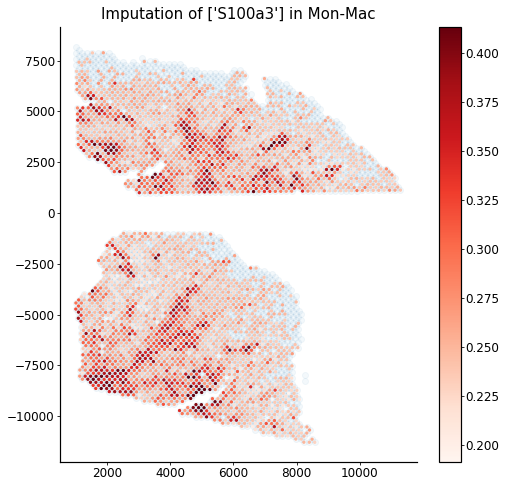

In [39]:
plt.figure(figsize=(8, 8))

name_ct = "Mon-Mac"
# gene_name = ["Hmox1", "Hilpda", "Gpnmb"]
gene_name=["S100a3"]


# get data
filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
locations = st_adata.obsm["location"][filter_]
proportions = st_adata.obsm["proportions"][name_ct].values[filter_]

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e5 * imp_ge)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=5, cmap="Reds", vmax=vmax)
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {name_ct}")
plt.show()

# Refined analysis of macrophages

In [40]:
# Step 1, run hotpost and check the modules
# Step 2, check those modules on the single-cell data
# Step 3, do a molecular signature analysis of the hypoxic zone vs the rest

In [42]:
# run hotspot
name_ct = "Macrophages"
sc_adata_slice = sc_adata[sc_adata.obs["broad_labels_"] == name_ct]
loc = pd.DataFrame(data=sc_adata_slice.obsm["X_CondSCVI"], index=sc_adata_slice.obs.index)
df = pd.DataFrame(data=sc_adata_slice.X.A.T, columns=sc_adata_slice.obs.index, index=sc_adata_slice.var.index)
# run hotspot
hs = hotspot.Hotspot(df, model='danb', latent=loc,)
hs.create_knn_graph(
        weighted_graph=True, n_neighbors=20,
    )
hs_results = hs.compute_autocorrelations(jobs=1)


Removing 69 undetected/non-varying genes


100%|██████████| 2817/2817 [00:01<00:00, 2471.44it/s]


In [85]:
hs_genes = hs_results.index[hs_results["FDR"] < 0.0005]
hs_genes

Index(['Gm42418', 'Gm26917', 'Hp', 'Lyz2', 'H2-Aa', 'Plac8', 'H2-Eb1', 'Ifit3',
       'Cd74', 'Rsad2',
       ...
       'Bgn', 'Wls', 'Pnp2', 'Batf', 'Ccdc58', 'Esyt1', 'Rnf144a', 'Dst',
       'Skap1', 'Ssr2'],
      dtype='object', name='Gene', length=786)

In [ ]:
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4)

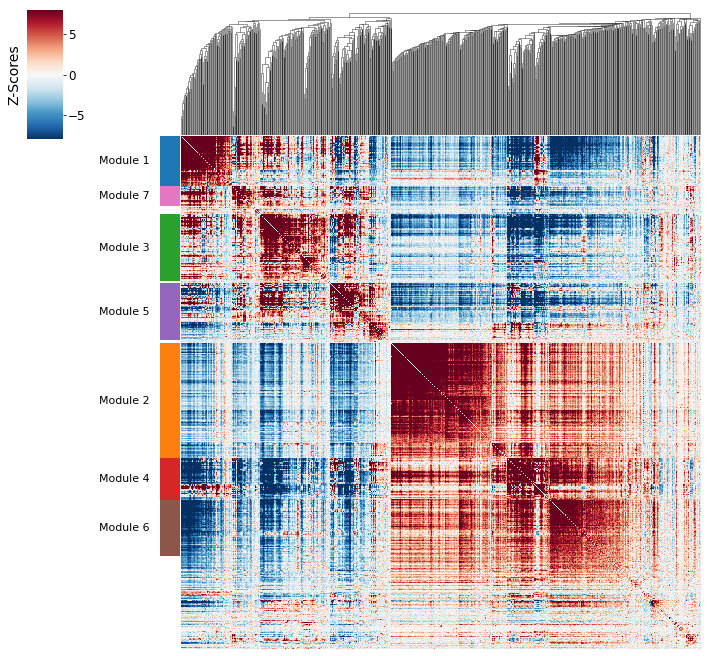

In [101]:
modules = hs.create_modules(
    min_gene_threshold=30, core_only=True, fdr_threshold=0.1
)

hs.plot_local_correlations()

In [113]:
for module in range(1, 8):
    print(f"Module {module}:")
    gl = list(hs.results.loc[hs.modules.index[np.where(hs.modules == module)[0]]].index[:50])
    print(", ".join(gl) + "\n")
    enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
    print(", ".join(enr.results.head(10)["Term"].values) + "\n")

Module 1:
Ifit3, Rsad2, Ifit2, Cxcl10, Ifit1, Ifit1bl1, Ly6a, Gbp2, Slfn5, Cmpk2, Ifi205, Ifit3b, Usp18, Isg20, Slfn4, Oasl1, Ifi208, AW112010, Mxd1, Irgm1, Samd9l, Phf11d, Socs1, Igtp, Ifih1, Ly6i, Pnp, Gbp5, Slfn9, Acod1, Cd69, Slamf7, Iigp1, Bst2, Tlr9, Ccl5, Scimp, Cd40, Il18bp, Klrk1, Ccl4, Flt1, Rilpl1, Sectm1a, Gm4951, Ifi44, Lipg, Gm13822, Tnfsf8, Ifi214

Interferon alpha/beta signaling, Interferon signaling, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, TNF-alpha effects on cytokine activity, cell motility, and apoptosis, Toll-like receptor signaling pathway regulation, Immune system, Cytokine-cytokine receptor interaction, Type II interferon signaling (interferon-gamma), Malaria, Binding of chemokines to chemokine receptors

Module 2:
Birc5, Selenop, Cdca3, Mki67, Stmn1, Cdca8, Ccnb2, Cks1b, Nusap1, Ccna2, Cenpe, Knstrn, Ckap2l, Ube2c, Plk1, Ccnb1, Cenpf, Mcm6, Cenpa, Top2a, Asf1b, Anln, Tpx2, Kif20b, Smc2, Cdk1, Kif11, Prc1, Tacc3, Hmm

In [127]:
hs.modules[["C1qa", "C1qa", "Cx3cr1", "Spp1", "Apoe", "Ms4a7"]]

Gene
C1qa      4
C1qa      4
Cx3cr1    4
Spp1      4
Apoe      5
Ms4a7     4
Name: Module, dtype: int64

In [162]:
hs.modules[["Arg1", "Hmox1", "Hilpda", "Gpnmb", "Mmp12", "Il7r"]]

Gene
Arg1      5
Hmox1     5
Hilpda    5
Gpnmb     5
Mmp12     5
Il7r      5
Name: Module, dtype: int64

In [43]:
# Modules of interest
# ------ Arg1-
# ---------- MHC-II Module 7 
gene_mhc = ["H2-Aa", "H2-Eb1", "Cd74", "H2-Ab1", "H2-DMb1"]
# ---------- Monocytes markers Module 3
gene_mono = ["Ly6c2", "Plac8", "Ly6a"]
# ---------- INF I Module 1
gene_ifn = ["Ifit1", "Ifit2", "Ifit3", "Isg15"]
# ------ Arg1+
# ---------- Hypoxia Module 5 / Mreg 
gene_hypox = ["Arg1", "Hmox1", "Hilpda", "Gpnmb", "Mmp12", "Il7r"]
# ---------- C1qa Module 4 / Tumor associated macrophages
gene_ctam = ["C1qa", "C1qa", "Cx3cr1", "Spp1", "Apoe", "Ms4a7"]

In [44]:
import umap
dim_red = umap.UMAP(n_neighbors=30)
slice_data = sc_adata[sc_adata.obs["broad_labels"] == "Mon-Mac"]
result = dim_red.fit_transform(slice_data.obsm["X_scVI"])

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [45]:
name_ct = "Mon-Mac"
# get data
filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
locations = st_adata.obsm["location"][filter_]
proportions = st_adata.obsm["proportions"][name_ct].values[filter_]

# impute
imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel/__main__.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


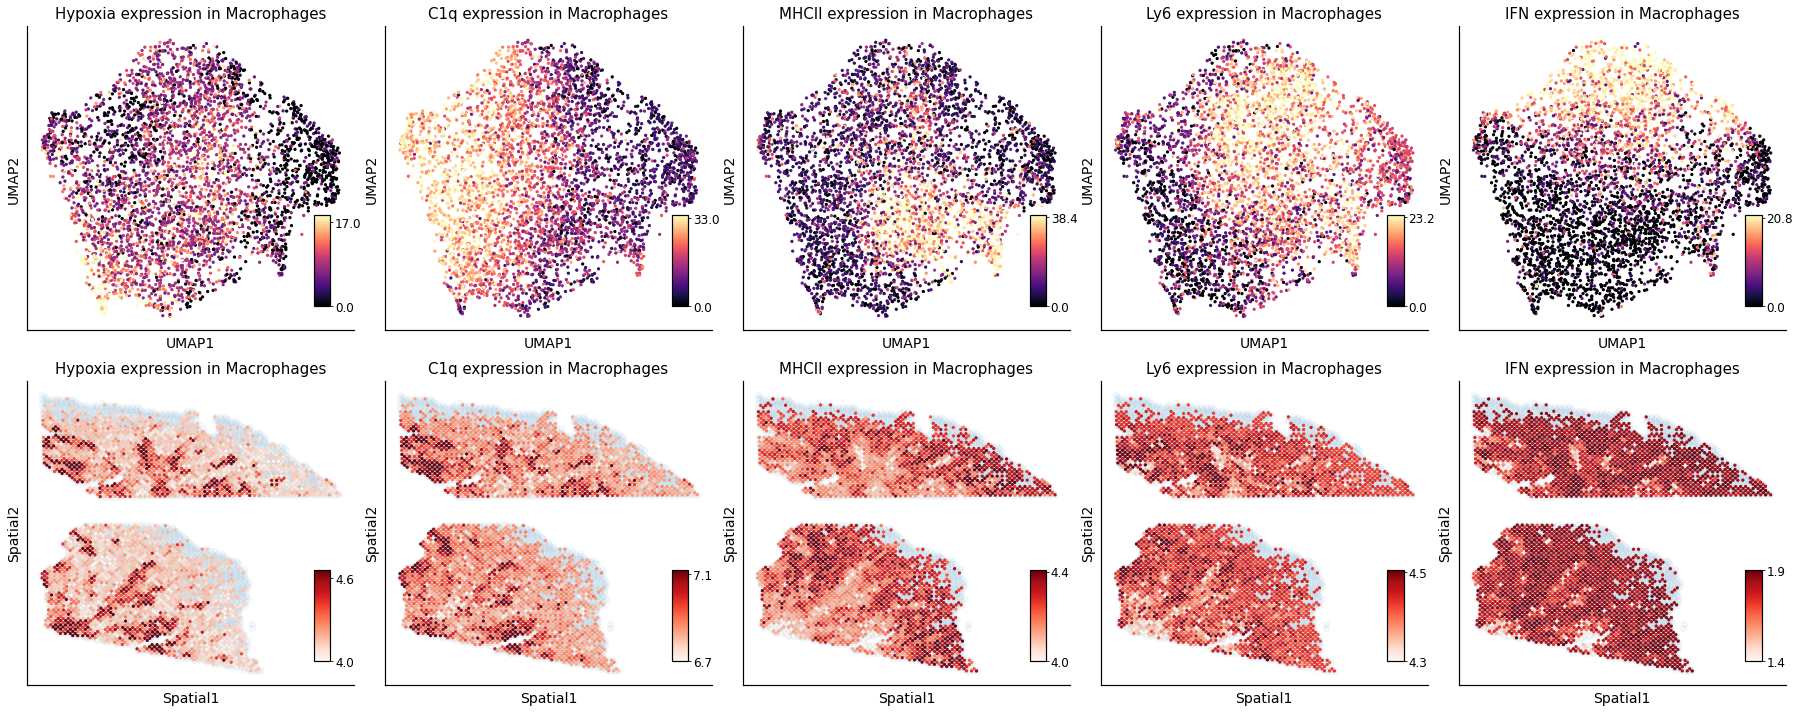

In [47]:
plt.figure(figsize=(25, 10))
names = ["Hypoxia", "C1q", "MHCII", "Ly6", "IFN"]
for i, gene_name in enumerate([gene_hypox, gene_ctam, gene_mhc, gene_mono, gene_ifn]):
    gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]

    # top plot
    ax1 = plt.subplot(2, 5, 1 + i)
    vector = np.sum(slice_data.X.A[:, gene_idx], axis=1)
    vmax = np.quantile(vector, 0.95)
    sc_plot = plt.scatter(result[:, 0], result[:, 1], c=vector, s=5, cmap="magma", vmax=vmax)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"{names[i]} expression in Macrophages")
    plt.xticks([])
    plt.yticks([])
    a, b = np.quantile(vector, 0.01),np.quantile(vector, 0.93)
    ta, tb = ["{:0.1f}".format(x) for x in (a, b)]
    cax = inset_axes(plt.gca(), width="5%", height="30%", loc=4, borderpad=2) 
    cbar = plt.colorbar(sc_plot, cax=cax, orientation="vertical")
    cbar.set_ticks([a, b])
    cbar.set_ticklabels([ta, tb])
    # bottom plot
    ax1 = plt.subplot(2, 5, 1 + i+5)
    imp_module = np.sum(imp_ge[:, gene_idx], 1)
    imp_module = np.log(1 + 1e5 * imp_module)
    vmax = np.quantile(imp_module, 0.94)
    vmin = np.quantile(imp_module, 0.01)
    # plot
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
    st_plot = plt.scatter(locations[:, 0], locations[:, 1], 
                c=imp_module, s=5, cmap="Reds", vmax=vmax, vmin=vmin)
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    plt.title(f"{names[i]} expression in Macrophages")
    plt.xticks([])
    plt.yticks([])
    a, b = np.quantile(imp_module, 0.01), np.quantile(imp_module, 0.93)
    ta, tb = ["{:0.1f}".format(x) for x in (a, b)]
    cax = inset_axes(plt.gca(), width="5%", height="30%", loc=4, borderpad=2) 
    cbar = plt.colorbar(st_plot, cax=cax, orientation="vertical")
    cbar.set_ticks([a, b])
    cbar.set_ticklabels([ta, tb])
    
plt.tight_layout()
plt.savefig("figures/Mac_gene_expression.pdf")

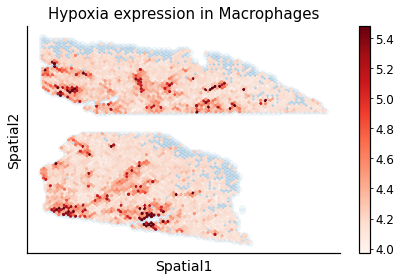

In [48]:
# now let's define an hypoxic zone and perform DE
gene_idx = np.where([x in gene_hypox for x in st_adata.var.index])[0]
imp_module = np.sum(imp_ge[:, gene_idx], 1)
imp_module = np.log(1 + 1e5 * imp_module)
vmax = np.quantile(imp_module, 0.99)
vmin = np.quantile(imp_module, 0.01)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_module, s=5, cmap="Reds", vmax=vmax)
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.title(f"{names[0]} expression in Macrophages")
plt.xticks([])
plt.colorbar()
plt.yticks([])
plt.tight_layout()
plt.show()


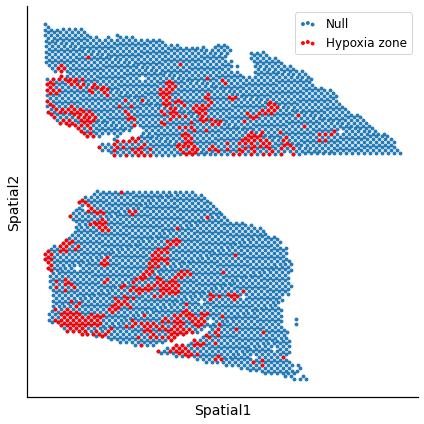

In [52]:
plt.figure(figsize=(6, 6))
threshold=4.4
mask_hypoxia = imp_module > threshold
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], label="Null", s=8)
plt.scatter(locations[mask_hypoxia, 0], locations[mask_hypoxia, 1], s=8, c="r", vmax=vmax, label="Hypoxia zone")
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.xticks([])
plt.legend(frameon=True)
plt.yticks([])
plt.tight_layout()
plt.show()

In [53]:
# get statistics
avg_library_size = np.mean(np.sum(st_adata.layers["counts"], axis=1).flatten())
exp_px_o = st_model.module.px_o.detach().exp().cpu().numpy()
mean = avg_library_size * imp_ge

# create distribution
concentration = torch.tensor(avg_library_size * imp_ge / exp_px_o)
rate = torch.tensor(1. / exp_px_o)

mask_non_hypoxia = np.random.choice(np.where(~mask_hypoxia)[0], size=(361))

# slice conditions
print(np.sum(mask_hypoxia), np.sum(mask_non_hypoxia))

# generate 
Na, Nb = (20, 20)
simulated_case = Gamma(concentration=concentration[mask_hypoxia], rate = rate).sample((Na,)).cpu().numpy()
simulated_case = np.log(simulated_case + 1)
simulated_case = simulated_case.reshape((-1, simulated_case.shape[-1]))

simulated_control = Gamma(concentration=concentration[mask_non_hypoxia], rate = rate).sample((Nb,)).cpu().numpy()
simulated_control = np.log(simulated_control + 1)
simulated_control = simulated_control.reshape((-1, simulated_control.shape[-1]))

617 638605


In [54]:
de_ks =np.array([ks_2samp(simulated_case[:, gene], 
                       simulated_control[:, gene], 
                       alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])

In [62]:
de_ks[de_ks == 0] = np.min(de_ks[de_ks > 0])

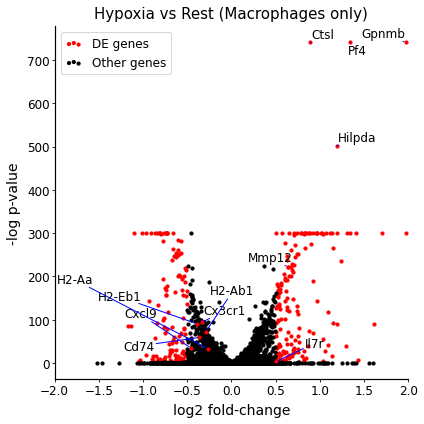

In [63]:
de = de_ks
max_pval = np.max(de[multipletests(de, method='fdr_bh')[0]])
lfc = np.log2(mean[mask_hypoxia].mean(0)) - np.log2(mean[mask_non_hypoxia].mean(0))
plt.figure(figsize=(6, 6))
# plot DE genes
mask = (de < max_pval) * (np.abs(lfc) > 0.5)
de_scatter = plt.scatter(lfc[mask], np.clip(-np.log(de[mask]), 0, 300), s=10, c="r")
nde_scatter = plt.scatter(lfc[~mask], np.clip(-np.log(de[~mask]), 0, 300), s=10, c="black")
plt.xlabel("log2 fold-change")
plt.ylabel("-log p-value")
plt.xlim((-2, 2))
plt.legend((de_scatter, nde_scatter), ("DE genes", "Other genes"), frameon=True)

interesting_genes = ["Gpnmb", "Hilpda", "Cx3cr1", "Mmp12", "Ctsl", "Pf4", "Il7r",
                     "H2-Aa", "H2-Ab1", "H2-Eb1", "Cxcl9", "Cd74"]
texts = []
for i, gene in enumerate(interesting_genes):
    ind = np.where(st_adata.var.index == gene)[0]
    x_coord, y_coord = lfc[ind], -np.log(de)[ind]
    plt.scatter(x_coord, y_coord, c="r", s=10)
    texts += [plt.text(x_coord, y_coord, gene, fontsize=12)]
adjust_text(texts, lfc, -np.log(de), arrowprops=dict(arrowstyle="-", color='blue'))
plt.title("Hypoxia vs Rest (Macrophages only)")
plt.tight_layout()
plt.savefig("figures/volcano_Hypoxia.pdf", dpi=DPI)

In [64]:
print("Hypoxia enriched: " + ", ".join(st_adata.var.index[np.where((lfc > 0.5) * (de < max_pval ))[0]].values))
print("Null enriched: " + ", ".join(st_adata.var.index[np.where((lfc < -0.5) * (de < max_pval ))[0]].values))

Hypoxia enriched: 4930556M19Rik, AA986860, Abca1, Adam8, Adarb1, Adm, Ager, Angpt1, Ankrd33b, Anxa8, Apex2, Arg1, Arhgap32, Arsg, B4galt2, Bnip3, Ccdc80, Ccl3, Ccl6, Ccl7, Ccl9, Cd63, Cdc42ep1, Cdr2l, Cdyl2, Ces1g, Chac1, Colec12, Csrnp2, Cth, Ctsl, Cxcl1, Cyp7b1, Ddah2, Dennd6b, Dmpk, Dnmt3l, Dpep3, Eaf2, Echdc3, Eda2r, Ednrb, Eepd1, Emp1, Enpp1, Epas1, Etv1, F13a1, Fabp5, Fads2, Fam160a1, Fam178b, Fam71e1, Fam83h, Fgf7, Folr2, Fosl1, Gadd45b, Galnt18, Gata2, Gja1, Gm13056, Gm17066, Gm31105, Gnao1, Gpihbp1, Gpnmb, Gstm5, Hbegf, Hilpda, Hist1h2bc, Hmox1, Hoxa9, Hspb1, Ier3, Inhba, Lif, Ltbp1, Lzts2, Mafb, Maoa, Mapk12, Me1, Mmp12, Mmp13, Mmp9, Mrc1, Ms4a14, Msln, Mt1, Mt2, Mtcl1, Myh10, Nav3, Nceh1, Ndrg1, Nfatc4, Nhsl1, Ninj1, Nos2, Npy, Nudt12, Nupr1l, Nxpe5, Obsl1, P4ha2, Pacsin3, Pdgfc, Pf4, Pgf, Ppp1r13l, Pyroxd2, Rab30, Rab39b, Ralgds, Rassf8, Rcn3, Reep6, Rgcc, Rhod, Rnf183, Rptoros, Rtel1, Rtkn, S100a3, S100g, Sapcd2, Sbsn, Sdc4, Slamf7, Slc27a3, Snhg12, Snhg18, Sorbs3, Stx1a, 

In [65]:
print(", ".join(st_adata.var.index[np.where((lfc > 0.5) * (de < np.exp(-150) ))[0]].values))

Abca1, Adam8, Adm, Ager, Arg1, Bnip3, Ccl6, Ccl7, Ccl9, Cd63, Colec12, Csrnp2, Ctsl, Ddah2, Echdc3, Emp1, Etv1, F13a1, Fabp5, Folr2, Fosl1, Galnt18, Gja1, Gpihbp1, Gpnmb, Gstm5, Hilpda, Hist1h2bc, Hmox1, Hoxa9, Ier3, Inhba, Ltbp1, Lzts2, Me1, Mmp12, Ms4a14, Msln, Mt1, Mt2, Mtcl1, Nceh1, Ndrg1, Ninj1, Obsl1, P4ha2, Pacsin3, Pf4, Ppp1r13l, Pyroxd2, Rassf8, Rcn3, Rtkn, S100g, Sdc4, Slc27a3, Snhg12, Snhg18, Sorbs3, Syngr1, Tceal8, Thbs1, Tmem37, Tspan3, Tspan9, Vat1, Vcl, Vldlr, Wwtr1, Ypel2
